In [ ]:
import kagglehub
from scipy.sparse import csr_matrix, coo_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Read from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Examine Data

In [ ]:
data = pd.read_csv("/content/drive/My Drive/collaborative_filtering/songsDataset.csv", delimiter=',')

In [ ]:
data.head()

,'userID','songID','rating'
0,0,7171,5
1,0,8637,4
2,0,21966,4
3,0,35821,5
4,0,82446,5


In [ ]:
data.shape

(2000000, 3)

In [ ]:
data.columns

Index([''userID'', ''songID'', ''rating''], dtype='object')

In [ ]:
data["'userID'"].nunique()

200000

In [ ]:
data["'songID'"].nunique()

127771

## Create a sparse matrix and test-mask matrix

In [ ]:
suffled_data = data.sample(frac=1, random_state=42)
N = 10000  # Take N samples for test
df_test = suffled_data.tail(N)
df_train = suffled_data.iloc[:-N]
# Map indices for sparse matrix. Make sure thats test users/songs exist in the matrix shape.
users = pd.Index(suffled_data["'userID'"].unique())
songs = pd.Index(suffled_data["'songID'"].unique())

user_to_idx = {u: i for i, u in enumerate(users)}
song_to_idx = {s: i for i, s in enumerate(songs)}

# Now create the sparse matrix only with the train data
row = df_train["'userID'"].map(user_to_idx)
col = df_train["'songID'"].map(song_to_idx)
data = df_train["'rating'"]

num_users = len(users)
num_songs = len(songs)

R_train = coo_matrix(
    (data, (row, col)),
    shape=(num_users, num_songs)
).tocsr()

# SVD Cross-Validation with Surprise

This notebook performs:
1. **Phase 1**: Cross-validation to find optimal `n_factors` (k)
2. **Phase 2**: Random search over hyperparameters (lr, reg, epochs)
3. **Phase 3**: Final model training and test set evaluation

**Assumes**: `R_train` sparse matrix is already loaded from previous cells.

In [ ]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 5.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp312-cp312-linux_x86_64.whl size=2554974 sha256=41ba0977c74d526082b2ca553e4da4e59d4939dcffc89522ce753d1fa39a8ff3
  Stored in directory: /root/.cache/pip/wheels/75/fa/bc/739bc2cb1fbaab6061854e6cfbb81a0ae52c92a502a7fa454b
Successfully built scikit-surprise


In [ ]:
!pip install "numpy<2" --quiet

In [ ]:
!pip install scikit-surprise --quiet

In [ ]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse

from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate, KFold

import warnings
warnings.filterwarnings('ignore')

print("Imports complete.")

Imports complete.


In [ ]:
# Support function - sparse_to_ratings_df()

def sparse_to_ratings_df(sparse_matrix):
    """
    Convert a sparse matrix to a ratings DataFrame for Surprise.

    Parameters
    ----------
    sparse_matrix : scipy.sparse matrix
        User-item matrix with ratings as values

    Returns
    -------
    pd.DataFrame
        DataFrame with columns: user_id, item_id, rating
    """
    # Convert to COO format for efficient extraction
    coo = sparse.coo_matrix(sparse_matrix)

    df = pd.DataFrame({
        'user_id': coo.row,
        'item_id': coo.col,
        'rating': coo.data
    })

    return df

print("Function sparse_to_ratings_df() defined.")

Function sparse_to_ratings_df() defined.


In [ ]:
# Execute conversion

ratings_df = sparse_to_ratings_df(R_train)

print(f"Ratings DataFrame shape: {ratings_df.shape}")
print(f"Number of unique users: {ratings_df['user_id'].nunique():,}")
print(f"Number of unique items: {ratings_df['item_id'].nunique():,}")
print(f"Rating range: [{ratings_df['rating'].min()}, {ratings_df['rating'].max()}]")
print()
print("Sample ratings:")
print(ratings_df.head(10))

Ratings DataFrame shape: (1990000, 3)
Number of unique users: 200,000
Number of unique items: 127,684
Rating range: [1, 5]

Sample ratings:
   user_id  item_id  rating
0        0        0       5
1        0       10       5
2        0     1055       5
3        0     1445       5
4        0     2756       5
5        0     2958       5
6        0     4401       5
7        0     7668       5
8        0    13425       5
9        0    38798       5


In [ ]:
ratings_df.head()

,user_id,item_id,rating
0,0,0,5
1,0,10,5
2,0,1055,5
3,0,1445,5
4,0,2756,5


In [ ]:
# Module 1 - prepare_surprise_data()

def prepare_surprise_data(ratings_df, rating_scale=(1, 5)):
    """
    Convert a ratings DataFrame to a Surprise Dataset object.

    Parameters
    ----------
    ratings_df : pd.DataFrame
        DataFrame with columns: user_id, item_id, rating
    rating_scale : tuple
        (min_rating, max_rating) for the Reader

    Returns
    -------
    surprise.Dataset
        Dataset object ready for cross-validation
    """
    reader = Reader(rating_scale=rating_scale)

    dataset = Dataset.load_from_df(
        ratings_df[['user_id', 'item_id', 'rating']],
        reader
    )

    return dataset

In [ ]:
# Execute data preparation

# Detect rating scale from data
min_rating = int(ratings_df['rating'].min())
max_rating = int(ratings_df['rating'].max())

dataset = prepare_surprise_data(ratings_df, rating_scale=(min_rating, max_rating))

print(f"Surprise Dataset created successfully.")
print(f"Rating scale: ({min_rating}, {max_rating})")
print(f"Ready for cross-validation.")

Surprise Dataset created successfully.
Rating scale: (1, 5)
Ready for cross-validation.


---
## Phase 1: Find Optimal n_factors (k)

We perform K-fold cross-validation for different values of `n_factors`, keeping other hyperparameters fixed.

In [ ]:
# Support function - run_single_factor_cv()

def run_single_factor_cv(dataset, n_factors, n_folds=5, n_epochs=20,
                          lr_all=0.005, reg_all=0.02, random_state=42, verbose=False):
    """
    Run cross-validation for a single n_factors value.

    Parameters
    ----------
    dataset : surprise.Dataset
        The dataset to cross-validate on
    n_factors : int
        Number of latent factors
    n_folds : int
        Number of CV folds
    n_epochs : int
        Number of SGD epochs
    lr_all : float
        Learning rate for all parameters
    reg_all : float
        Regularization for all parameters
    random_state : int
        Random seed for reproducibility
    verbose : bool
        Print training progress

    Returns
    -------
    dict
        Dictionary with 'test_rmse', 'test_mae', 'fit_time' arrays
    """
    algo = SVD(
        n_factors=n_factors,
        n_epochs=n_epochs,
        lr_all=lr_all,
        reg_all=reg_all,
        random_state=random_state,
        verbose=verbose
    )

    cv_results = cross_validate(
        algo,
        dataset,
        measures=['RMSE', 'MAE'],
        cv=n_folds,
        verbose=False
    )

    return cv_results

print("Function run_single_factor_cv() defined.")

Function run_single_factor_cv() defined.


In [ ]:
# Module 2 - cross_validate_svd_factors()

def cross_validate_svd_factors(dataset, factor_range, n_folds=5, n_epochs=20,
                                lr_all=0.005, reg_all=0.02, random_state=42):
    """
    Perform cross-validation over multiple n_factors values to find optimal k.

    Parameters
    ----------
    dataset : surprise.Dataset
        The dataset to cross-validate on
    factor_range : list
        List of n_factors values to test
    n_folds : int
        Number of CV folds
    n_epochs : int
        Number of SGD epochs
    lr_all : float
        Learning rate for all parameters
    reg_all : float
        Regularization for all parameters
    random_state : int
        Random seed

    Returns
    -------
    dict
        Results dictionary with n_factors, mean_rmse, std_rmse, etc.
    """
    results = {
        'n_factors': [],
        'mean_rmse': [],
        'std_rmse': [],
        'mean_mae': [],
        'std_mae': [],
        'mean_fit_time': []
    }

    print("Starting cross-validation over n_factors...")
    print("=" * 60)

    for n_factors in factor_range:
        print(f"Testing n_factors={n_factors}...", end=" ")

        cv_results = run_single_factor_cv(
            dataset=dataset,
            n_factors=n_factors,
            n_folds=n_folds,
            n_epochs=n_epochs,
            lr_all=lr_all,
            reg_all=reg_all,
            random_state=random_state
        )

        # Extract statistics
        mean_rmse = np.mean(cv_results['test_rmse'])
        std_rmse = np.std(cv_results['test_rmse'])
        mean_mae = np.mean(cv_results['test_mae'])
        std_mae = np.std(cv_results['test_mae'])
        mean_fit_time = np.mean(cv_results['fit_time'])

        # Store results
        results['n_factors'].append(n_factors)
        results['mean_rmse'].append(mean_rmse)
        results['std_rmse'].append(std_rmse)
        results['mean_mae'].append(mean_mae)
        results['std_mae'].append(std_mae)
        results['mean_fit_time'].append(mean_fit_time)

        print(f"RMSE={mean_rmse:.4f} ± {std_rmse:.4f}, MAE={mean_mae:.4f}, Time={mean_fit_time:.1f}s")

    print("=" * 60)
    print("Cross-validation complete.")

    return results

print("Function cross_validate_svd_factors() defined.")

Function cross_validate_svd_factors() defined.


In [ ]:
# Print CV parameters before running

# Define hyperparameters for Phase 1
FACTOR_RANGE = [3, 5, 7, 10, 15, 20]
N_FOLDS = 5
N_EPOCHS = 20
LR_ALL = 0.005
REG_ALL = 0.02
RANDOM_STATE = 42

print("Phase 1: Cross-Validation Parameters")
print("=" * 40)
print(f"n_factors to test: {FACTOR_RANGE}")
print(f"Number of folds:   {N_FOLDS}")
print(f"Epochs per model:  {N_EPOCHS}")
print(f"Learning rate:     {LR_ALL}")
print(f"Regularization:    {REG_ALL}")
print(f"Random state:      {RANDOM_STATE}")
print("=" * 40)
print(f"Total models to train: {len(FACTOR_RANGE) * N_FOLDS}")

Phase 1: Cross-Validation Parameters
n_factors to test: [3, 5, 7, 10, 15, 20]
Number of folds:   5
Epochs per model:  20
Learning rate:     0.005
Regularization:    0.02
Random state:      42
Total models to train: 30


- Testing n_factors=10... RMSE=1.3474 ± 0.0009, MAE=1.1378, Time=26.3s
- Testing n_factors=20... RMSE=1.3511 ± 0.0010, MAE=1.1408, Time=28.2s
- Testing n_factors=50... RMSE=1.3606 ± 0.0012, MAE=1.1499, Time=37.4s
- Testing n_factors=100... RMSE=1.3708 ± 0.0007, MAE=1.1604, Time=46.6s
- Testing n_factors=150... RMSE=1.3782 ± 0.0007, MAE=1.1691, Time=55.8s

In [ ]:
# Execute CV

cv_results = cross_validate_svd_factors(
    dataset=dataset,
    factor_range=FACTOR_RANGE,
    n_folds=N_FOLDS,
    n_epochs=N_EPOCHS,
    lr_all=LR_ALL,
    reg_all=REG_ALL,
    random_state=RANDOM_STATE
)

Starting cross-validation over n_factors...
Testing n_factors=3... RMSE=1.3443 ± 0.0017, MAE=1.1355, Time=25.8s
Testing n_factors=5... RMSE=1.3446 ± 0.0005, MAE=1.1358, Time=26.5s
Testing n_factors=7... RMSE=1.3465 ± 0.0009, MAE=1.1373, Time=27.0s
Testing n_factors=10... RMSE=1.3473 ± 0.0006, MAE=1.1378, Time=27.7s
Testing n_factors=15... RMSE=1.3495 ± 0.0017, MAE=1.1397, Time=29.1s
Testing n_factors=20... RMSE=1.3516 ± 0.0015, MAE=1.1414, Time=31.1s
Cross-validation complete.


In [ ]:
# Execute CV with higher n epochs

cv_results = cross_validate_svd_factors(
    dataset=dataset,
    factor_range=[3,5,7],
    n_folds=3,
    n_epochs=40,
    lr_all=LR_ALL,
    reg_all=REG_ALL,
    random_state=RANDOM_STATE
)

Starting cross-validation over n_factors...
Testing n_factors=3... RMSE=1.3556 ± 0.0007, MAE=1.1059, Time=41.2s
Testing n_factors=5... RMSE=1.3600 ± 0.0006, MAE=1.1097, Time=42.1s
Testing n_factors=7... RMSE=1.3626 ± 0.0008, MAE=1.1124, Time=43.5s
Cross-validation complete.


In [ ]:
# Print results summary table

print("\nCross-Validation Results Summary")
print("=" * 70)
print(f"{'n_factors':>10} | {'RMSE':>15} | {'MAE':>15} | {'Fit Time':>10}")
print("-" * 70)

for i in range(len(cv_results['n_factors'])):
    n_factors = cv_results['n_factors'][i]
    rmse_str = f"{cv_results['mean_rmse'][i]:.4f} ± {cv_results['std_rmse'][i]:.4f}"
    mae_str = f"{cv_results['mean_mae'][i]:.4f} ± {cv_results['std_mae'][i]:.4f}"
    time_str = f"{cv_results['mean_fit_time'][i]:.1f}s"
    print(f"{n_factors:>10} | {rmse_str:>15} | {mae_str:>15} | {time_str:>10}")

print("=" * 70)

# Find best
best_idx = np.argmin(cv_results['mean_rmse'])
best_k = cv_results['n_factors'][best_idx]
best_rmse = cv_results['mean_rmse'][best_idx]

print(f"\n★ Best n_factors: {best_k} (RMSE = {best_rmse:.4f})")


Cross-Validation Results Summary
 n_factors |            RMSE |             MAE |   Fit Time
----------------------------------------------------------------------
         3 | 1.3443 ± 0.0017 | 1.1355 ± 0.0015 |      25.8s
         5 | 1.3446 ± 0.0005 | 1.1358 ± 0.0006 |      26.5s
         7 | 1.3465 ± 0.0009 | 1.1373 ± 0.0006 |      27.0s
        10 | 1.3473 ± 0.0006 | 1.1378 ± 0.0008 |      27.7s
        15 | 1.3495 ± 0.0017 | 1.1397 ± 0.0016 |      29.1s
        20 | 1.3516 ± 0.0015 | 1.1414 ± 0.0014 |      31.1s

★ Best n_factors: 3 (RMSE = 1.3443)


In [ ]:
# Module 3 - plot_cv_results()

def plot_cv_results(results, title="SVD Cross-Validation: RMSE vs n_factors"):
    """
    Plot cross-validation results showing RMSE vs n_factors.

    Parameters
    ----------
    results : dict
        Results dictionary from cross_validate_svd_factors()
    title : str
        Plot title

    Returns
    -------
    matplotlib.figure.Figure
        The figure object
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    n_factors = results['n_factors']
    mean_rmse = results['mean_rmse']
    std_rmse = results['std_rmse']
    mean_mae = results['mean_mae']
    std_mae = results['std_mae']

    # Plot 1: RMSE
    ax1 = axes[0]
    ax1.errorbar(n_factors, mean_rmse, yerr=std_rmse, marker='o', capsize=5,
                 linewidth=2, markersize=8, color='steelblue')
    ax1.set_xlabel('n_factors (k)', fontsize=12)
    ax1.set_ylabel('RMSE', fontsize=12)
    ax1.set_title('RMSE vs n_factors', fontsize=14)
    ax1.grid(True, alpha=0.3)

    # Mark best point
    best_idx = np.argmin(mean_rmse)
    ax1.scatter([n_factors[best_idx]], [mean_rmse[best_idx]],
                color='red', s=150, zorder=5, marker='*', label=f'Best: k={n_factors[best_idx]}')
    ax1.legend()

    # Plot 2: MAE
    ax2 = axes[1]
    ax2.errorbar(n_factors, mean_mae, yerr=std_mae, marker='s', capsize=5,
                 linewidth=2, markersize=8, color='darkorange')
    ax2.set_xlabel('n_factors (k)', fontsize=12)
    ax2.set_ylabel('MAE', fontsize=12)
    ax2.set_title('MAE vs n_factors', fontsize=14)
    ax2.grid(True, alpha=0.3)

    plt.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout()

    return fig

print("Function plot_cv_results() defined.")

Function plot_cv_results() defined.


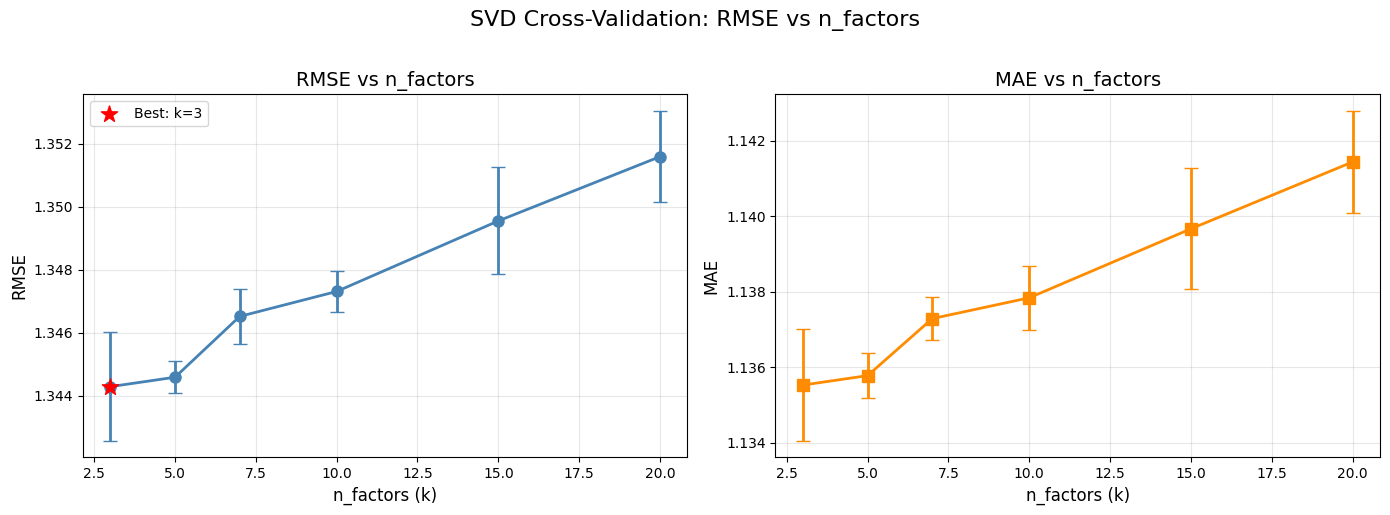


PHASE 1 CONCLUSION
Optimal n_factors (k): 3
CV RMSE at optimal k:  1.3443

Proceeding to Phase 2 with n_factors=3 fixed.


In [ ]:
# Execute plot + conclusion

fig = plot_cv_results(cv_results)
plt.show()

# Conclusion
print("\n" + "=" * 60)
print("PHASE 1 CONCLUSION")
print("=" * 60)
print(f"Optimal n_factors (k): {best_k}")
print(f"CV RMSE at optimal k:  {best_rmse:.4f}")
print(f"\nProceeding to Phase 2 with n_factors={best_k} fixed.")
print("=" * 60)

In [ ]:
# Change best k to be 5, because of the low variability
best_k = 5
print(f"New optimal k: {best_k}")

New optimal k: 5


---
## Phase 2: Random Search over Hyperparameters

With optimal `n_factors` fixed, we now search over:
- `n_epochs`: [15, 20, 25, 30, 40, 50]
- `lr_all`: [0.002, 0.005, 0.007, 0.01]
- `reg_all`: [0.01, 0.02, 0.05, 0.1]

In [ ]:
# random_search_svd()

def random_search_svd(dataset, n_factors, n_iter=20, n_folds=3, random_state=42):
    """
    Perform random search over SVD hyperparameters.

    Parameters
    ----------
    dataset : surprise.Dataset
        The dataset to search on
    n_factors : int
        Fixed number of latent factors (from Phase 1)
    n_iter : int
        Number of random configurations to try
    n_folds : int
        Number of CV folds (use 3 for speed)
    random_state : int
        Random seed

    Returns
    -------
    dict
        Best parameters and full search history
    """
    np.random.seed(random_state)

    # Define search space
    param_space = {
        'n_epochs': [15, 20, 25, 30, 40, 50],
        'lr_all': [0.002, 0.005, 0.007, 0.01],
        'reg_all': [0.01, 0.02, 0.05, 0.1]
    }

    search_history = []
    best_rmse = float('inf')
    best_params = None

    print(f"Starting random search with {n_iter} iterations...")
    print(f"Fixed n_factors={n_factors}")
    print("=" * 70)

    for i in range(n_iter):
        # Sample random configuration
        params = {
            'n_factors': n_factors,
            'n_epochs': np.random.choice(param_space['n_epochs']),
            'lr_all': np.random.choice(param_space['lr_all']),
            'reg_all': np.random.choice(param_space['reg_all'])
        }

        # Run CV
        algo = SVD(
            n_factors=params['n_factors'],
            n_epochs=params['n_epochs'],
            lr_all=params['lr_all'],
            reg_all=params['reg_all'],
            random_state=random_state
        )

        cv_results = cross_validate(algo, dataset, measures=['RMSE'], cv=n_folds, verbose=False)
        mean_rmse = np.mean(cv_results['test_rmse'])

        # Store result
        params['mean_rmse'] = mean_rmse
        search_history.append(params.copy())

        # Update best
        if mean_rmse < best_rmse:
            best_rmse = mean_rmse
            best_params = params.copy()
            marker = "★ NEW BEST"
        else:
            marker = ""

        print(f"[{i+1:2d}/{n_iter}] epochs={params['n_epochs']:2d}, lr={params['lr_all']:.3f}, "
              f"reg={params['reg_all']:.2f} → RMSE={mean_rmse:.4f} {marker}")

    print("=" * 70)
    print("Random search complete.")

    return {
        'best_params': best_params,
        'best_rmse': best_rmse,
        'search_history': search_history
    }

print("Function random_search_svd() defined.")

Function random_search_svd() defined.


In [ ]:
# Execute random search

# Use the best n_factors from Phase 1
OPTIMAL_K = best_k

search_results = random_search_svd(
    dataset=dataset,
    n_factors=OPTIMAL_K,
    n_iter=20,
    n_folds=3,
    random_state=42
)

print("\n" + "=" * 60)
print("PHASE 2 RESULTS: BEST HYPERPARAMETERS")
print("=" * 60)
print(f"n_factors: {search_results['best_params']['n_factors']}")
print(f"n_epochs:  {search_results['best_params']['n_epochs']}")
print(f"lr_all:    {search_results['best_params']['lr_all']}")
print(f"reg_all:   {search_results['best_params']['reg_all']}")
print(f"CV RMSE:   {search_results['best_rmse']:.4f}")
print("=" * 60)

Starting random search with 20 iterations...
Fixed n_factors=5
[ 1/20] epochs=30, lr=0.002, reg=0.05 → RMSE=1.3976 ★ NEW BEST
[ 2/20] epochs=40, lr=0.010, reg=0.05 → RMSE=1.3960 ★ NEW BEST
[ 3/20] epochs=40, lr=0.002, reg=0.02 → RMSE=1.3769 ★ NEW BEST
[ 4/20] epochs=15, lr=0.010, reg=0.10 → RMSE=1.3423 ★ NEW BEST
[ 5/20] epochs=20, lr=0.002, reg=0.05 → RMSE=1.4274 
[ 6/20] epochs=50, lr=0.005, reg=0.01 → RMSE=1.3897 
[ 7/20] epochs=25, lr=0.002, reg=0.02 → RMSE=1.4113 
[ 8/20] epochs=40, lr=0.007, reg=0.01 → RMSE=1.4024 
[ 9/20] epochs=20, lr=0.002, reg=0.10 → RMSE=1.4279 
[10/20] epochs=40, lr=0.002, reg=0.01 → RMSE=1.3773 
[11/20] epochs=20, lr=0.007, reg=0.01 → RMSE=1.3565 
[12/20] epochs=30, lr=0.010, reg=0.10 → RMSE=1.3411 ★ NEW BEST
[13/20] epochs=50, lr=0.010, reg=0.02 → RMSE=1.4616 
[14/20] epochs=20, lr=0.007, reg=0.10 → RMSE=1.3447 
[15/20] epochs=20, lr=0.010, reg=0.02 → RMSE=1.3597 
[16/20] epochs=50, lr=0.005, reg=0.02 → RMSE=1.3774 
[17/20] epochs=40, lr=0.005, reg=0.01 →

---
## Phase 3: Final Model Training & Test Evaluation

Train final model on full `R_train` with best hyperparameters, then evaluate on the held-out masked test set.

In [ ]:
# train_final_model()

def train_final_model(dataset, params, random_state=42):
    """
    Train final SVD model on full dataset with best parameters.

    Parameters
    ----------
    dataset : surprise.Dataset
        The full training dataset
    params : dict
        Best hyperparameters (n_factors, n_epochs, lr_all, reg_all)
    random_state : int
        Random seed

    Returns
    -------
    surprise.SVD
        Trained model
    """
    # Build full trainset
    trainset = dataset.build_full_trainset()

    # Create model with best params
    model = SVD(
        n_factors=params['n_factors'],
        n_epochs=params['n_epochs'],
        lr_all=params['lr_all'],
        reg_all=params['reg_all'],
        random_state=random_state,
        verbose=True
    )

    print("Training final model on full dataset...")
    model.fit(trainset)
    print("Training complete.")

    return model

print("Function train_final_model() defined.")

Function train_final_model() defined.


In [ ]:
# Execute final training

final_params = search_results['best_params']

print("Final Model Parameters:")
print(f"  n_factors: {final_params['n_factors']}")
print(f"  n_epochs:  {final_params['n_epochs']}")
print(f"  lr_all:    {final_params['lr_all']}")
print(f"  reg_all:   {final_params['reg_all']}")
print()

# Try run with lower regularization
final_params['reg_all'] = 0.001

final_model = train_final_model(dataset, final_params, random_state=42)

print(f"\nModel has {final_params['n_factors']} latent factors.")
print(f"User factors shape: ({final_model.trainset.n_users}, {final_params['n_factors']})")
print(f"Item factors shape: ({final_model.trainset.n_items}, {final_params['n_factors']})")

Final Model Parameters:
  n_factors: 5
  n_epochs:  30
  lr_all:    0.01
  reg_all:   0.001

Training final model on full dataset...
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Training complete.

Model has 5 latent factors.
User factors shape: (200000, 5)
Item factors shape: (127684, 5)


In [ ]:
# evaluate_on_test_set()

def evaluate_on_test_set(model, test_sparse_matrix, debug=False):
    """
    Evaluate the trained Surprise model on a sparse test matrix.

    Parameters
    ----------
    model : surprise.SVD
        Trained SVD model
    test_sparse_matrix : scipy.sparse matrix
        Sparse matrix with true ratings in test entries
    debug : bool
        Print sample predictions

    Returns
    -------
    dict
        Dictionary with rmse, mae, n_predictions, predictions array
    """
    # Extract test interactions
    coo = sparse.coo_matrix(test_sparse_matrix)
    test_users = coo.row
    test_items = coo.col
    true_ratings = coo.data

    print(f"Test set size: {len(true_ratings):,} ratings")

    # Generate predictions
    predictions = []
    valid_count = 0
    skipped_count = 0

    for user, item, true_r in zip(test_users, test_items, true_ratings):
        # Surprise uses inner ids, need to convert
        try:
            pred = model.predict(uid=user, iid=item)
            predictions.append({
                'user': user,
                'item': item,
                'true_rating': true_r,
                'pred_rating': pred.est
            })
            valid_count += 1
        except:
            skipped_count += 1

    if skipped_count > 0:
        print(f"Skipped {skipped_count} predictions (unknown users/items)")

    # Convert to arrays for calculation
    pred_df = pd.DataFrame(predictions)
    true_arr = pred_df['true_rating'].values
    pred_arr = pred_df['pred_rating'].values

    # Calculate metrics
    errors = pred_arr - true_arr
    mse = np.mean(errors ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(errors))

    if debug:
        print(f"\nSample predictions:")
        sample = pred_df.head(10)
        for _, row in sample.iterrows():
            print(f"  u={int(row['user']):6d}, i={int(row['item']):6d}, "
                  f"true={row['true_rating']:.1f}, pred={row['pred_rating']:.3f}")

    return {
        'rmse': rmse,
        'mae': mae,
        'mse': mse,
        'n_predictions': valid_count,
        'predictions_df': pred_df
    }

print("Function evaluate_on_test_set() defined.")

Function evaluate_on_test_set() defined.


In [ ]:
# Create R_test sparse matrix
row_test = df_test["'userID'"].map(user_to_idx)
col_test = df_test["'songID'"].map(song_to_idx)
data_test = df_test["'rating'"]

R_test = coo_matrix(
    (data_test, (row_test, col_test)),
    shape=(num_users, num_songs)
).tocsr()

In [ ]:
# Execute test evaluation

# NOTE: R_test should be your masked test set from the beginning of the notebook
# If you named it differently, update the variable name here

print("=" * 60)
print("FINAL TEST SET EVALUATION")
print("=" * 60)

test_results = evaluate_on_test_set(final_model, R_test, debug=True)

print("\n" + "=" * 60)
print("FINAL RESULTS")
print("=" * 60)
print(f"Test RMSE:        {test_results['rmse']:.4f}")
print(f"Test MAE:         {test_results['mae']:.4f}")
print(f"Predictions made: {test_results['n_predictions']:,}")
print("=" * 60)

# Compare to baselines
RANDOM_BASELINE_RMSE = 1.9  # from vector_similarity.ipynb
improvement = (RANDOM_BASELINE_RMSE - test_results['rmse']) / RANDOM_BASELINE_RMSE * 100

print(f"\nComparison to Random Baseline (RMSE={RANDOM_BASELINE_RMSE})")
print(f"Improvement: {improvement:.1f}%")
print("=" * 60)

FINAL TEST SET EVALUATION
Test set size: 10,000 ratings

Sample predictions:
  u=    11, i= 20394, true=5.0, pred=4.565
  u=    16, i=  2503, true=1.0, pred=4.738
  u=    38, i=  2386, true=3.0, pred=4.511
  u=    39, i= 27854, true=1.0, pred=2.982
  u=    40, i= 40635, true=5.0, pred=3.795
  u=    84, i=  7643, true=3.0, pred=4.867
  u=   106, i= 75963, true=2.0, pred=2.511
  u=   144, i= 43607, true=5.0, pred=3.354
  u=   145, i= 41941, true=5.0, pred=4.700
  u=   152, i=  4625, true=4.0, pred=3.502

FINAL RESULTS
Test RMSE:        1.4394
Test MAE:         1.1060
Predictions made: 10,000

Comparison to Random Baseline (RMSE=1.9)
Improvement: 24.2%


In [ ]:
# See actual predictions:

In [ ]:
predictions_df = df_test.copy()

predictions_df['predicted_rating'] = [
    final_model.predict(uid=user_to_idx[u], iid=song_to_idx[s]).est
    for u, s in zip(df_test["'userID'"], df_test["'songID'"])
]

predictions_df['error'] = predictions_df["'rating'"] - predictions_df['predicted_rating']

predictions_df.head(20)

,'userID','songID','rating',predicted_rating,error
739127,73912,124556,3,2.776974,0.223026
611796,61179,102348,3,3.846787,-0.846787
1721654,172165,83438,3,1.909253,1.090747
1335883,133588,34110,5,5.000000,0.000000
1694512,169451,31617,1,2.505489,-1.505489
431739,43173,104992,5,3.054783,1.945217
391670,39167,10819,3,4.496091,-1.496091
975601,97560,13049,4,4.169354,-0.169354
715768,71576,112580,5,4.464244,0.535756
1545329,154532,120525,5,3.274342,1.725658


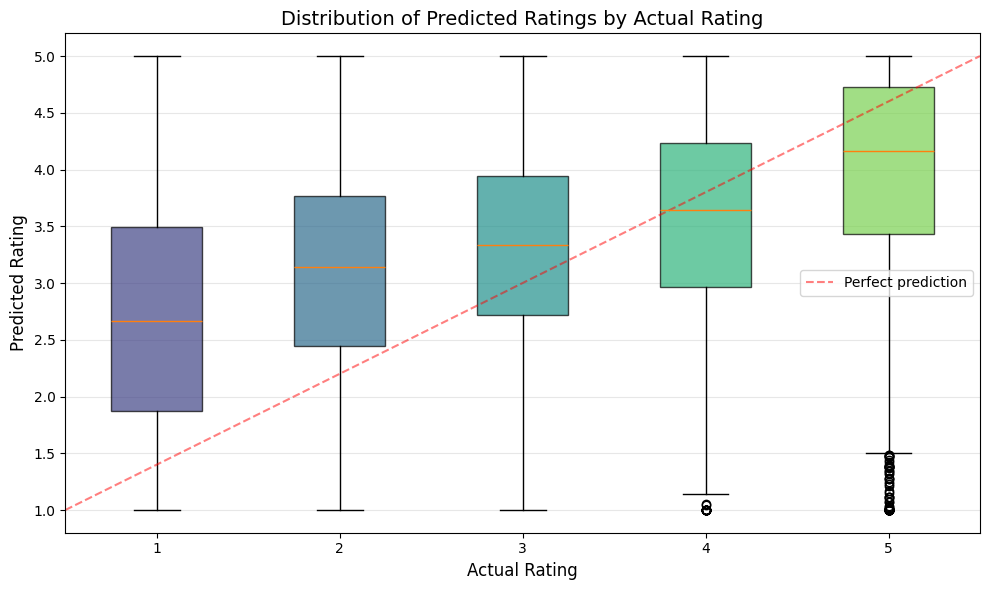

In [ ]:
# Boxplot: predicted ratings distribution by actual rating

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

# Group by actual rating and plot predicted values
ratings = sorted(predictions_df["'rating'"].unique())
data_to_plot = [predictions_df[predictions_df["'rating'"] == r]['predicted_rating'] for r in ratings]

bp = ax.boxplot(data_to_plot, labels=ratings, patch_artist=True)

# Style the boxes
colors = plt.cm.viridis([0.2, 0.35, 0.5, 0.65, 0.8])
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Add diagonal reference line (perfect prediction)
ax.plot([0.5, len(ratings) + 0.5], [ratings[0], ratings[-1]],
        'r--', alpha=0.5, label='Perfect prediction')

ax.set_xlabel('Actual Rating', fontsize=12)
ax.set_ylabel('Predicted Rating', fontsize=12)
ax.set_title('Distribution of Predicted Ratings by Actual Rating', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [ ]:
# Results are centered

In [ ]:
# Sparsity analysis
n_users = df_train["'userID'"].nunique()
n_items = df_train["'songID'"].nunique()
n_ratings = len(df_train)

sparsity = 1 - (n_ratings / (n_users * n_items))

ratings_per_user = df_train.groupby("'userID'").size()
ratings_per_item = df_train.groupby("'songID'").size()

print(f"Users: {n_users:,}")
print(f"Items: {n_items:,}")
print(f"Ratings: {n_ratings:,}")
print(f"Sparsity: {sparsity:.6f} ({sparsity*100:.4f}%)")
print()
print(f"Ratings per user - median: {ratings_per_user.median():.0f}, mean: {ratings_per_user.mean():.1f}")
print(f"Ratings per item - median: {ratings_per_item.median():.0f}, mean: {ratings_per_item.mean():.1f}")

Users: 200,000
Items: 127,684
Ratings: 1,990,000
Sparsity: 0.999922 (99.9922%)

Ratings per user - median: 10, mean: 9.9
Ratings per item - median: 5, mean: 15.6


In [ ]:
from surprise import BaselineOnly

# Bias-only model
baseline_algo = BaselineOnly(bsl_options={'method': 'sgd', 'reg': 0.02, 'n_epochs': 20})
cv_baseline = cross_validate(baseline_algo, dataset, measures=['RMSE'], cv=3, verbose=False)
print(f"Baseline (biases only) RMSE: {np.mean(cv_baseline['test_rmse']):.4f}")
print(f"SVD RMSE:                    {best_rmse:.4f}")
print(f"Improvement from factors:    {np.mean(cv_baseline['test_rmse']) - best_rmse:.4f}")

Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Baseline (biases only) RMSE: 1.3607
SVD RMSE:                    1.3443
Improvement from factors:    0.0164


## Diagnosis Summary

| Metric | Your Data | Typical "Good" CF Data |
|--------|-----------|------------------------|
| Sparsity | 99.99% | 95-99% |
| Ratings/user | 10 (median) | 50+ |
| Ratings/item | 5 (median) | 20+ |
| SVD vs Baseline | +0.016 | +0.1 to +0.3 |

**The latent factors are essentially useless.** With only 10 ratings per user, there's not enough signal to learn meaningful user embeddings. The model falls back to: *"predict the global mean, adjusted by user/item bias"* — which is exactly what BaselineOnly does.

---

## Options

### Option 1: Filter to Active Users/Items (Recommended First Step)

Filter to users with ≥20 ratings and items with ≥10 ratings, then retrain SVD on the filtered data and compare.

### Option 2: Accept Baseline as Your Model

If pure CF can't beat biases, use biases. This is essentially:
```
prediction = global_mean + user_bias + item_bias
```

This is honest and interpretable: *"Users who rate high tend to rate high; popular songs get higher ratings."*

### Option 3: Hybrid Approach (If You Have Metadata)

| Feature Type | Example | Approach |
|--------------|---------|----------|
| Song metadata | genre, artist, year | Content-based filtering |
| User metadata | age, location | User clustering |
| Temporal | timestamp of rating | Time-weighted models |

With such sparse data, **content-based features often outperform collaborative filtering**.

### Option 4: Item-Based KNN

Sometimes works better for sparse data than matrix factorization.

---

## Bottom Line

With 10 ratings per user and 5 per item, **you're at the ceiling for pure collaborative filtering**. The RMSE of ~1.35 is likely close to the best achievable without additional data or features.